Fetching data for ^GSPC from 2007-01-01 to 2011-01-01...


[*********************100%***********************]  1 of 1 completed


Converted timezone-aware index to timezone-naive.
Data fetched successfully.
Annotated event: 'Peak of Bull Market' on 2007-10-11 at price 1554.41
Annotated event: 'Bear Stearns Fails' on 2008-03-12 at price 1308.77
Annotated event: 'Lehman Bankruptcy' on 2008-09-15 at price 1192.70


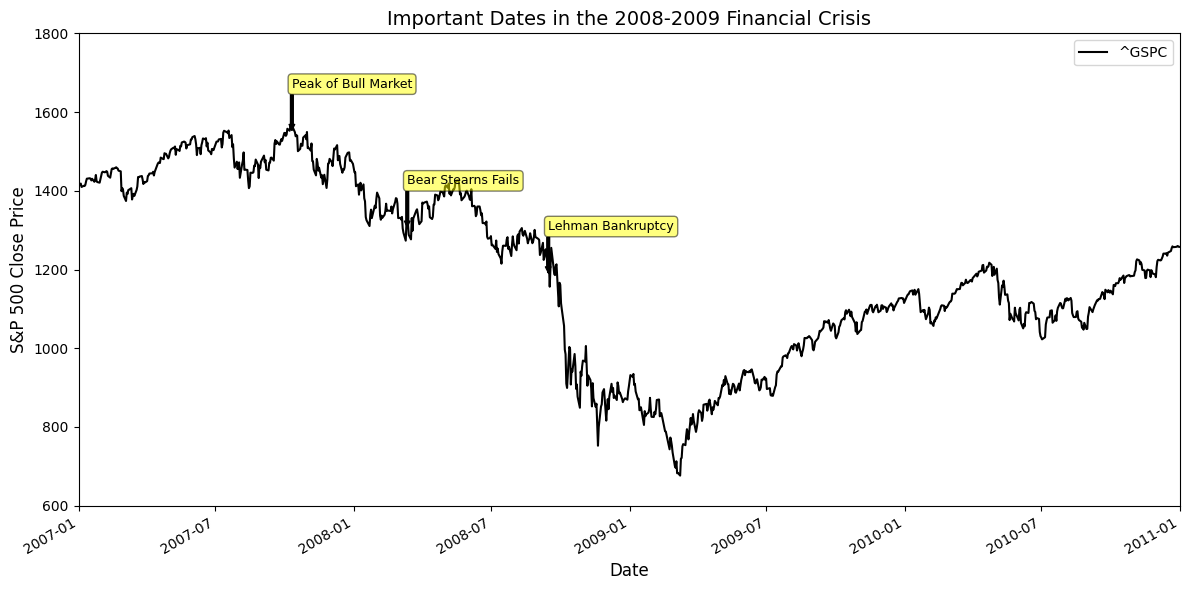

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def fetch_spx_data(ticker: str, start_date: str, end_date: str) -> pd.Series:
    """
    Fetches the closing price data for a given ticker symbol from Yahoo Finance.

    Parameters:
        ticker (str): The ticker symbol to fetch data for.
        start_date (str): The start date in 'YYYY-MM-DD' format.
        end_date (str): The end date in 'YYYY-MM-DD' format.

    Returns:
        pd.Series: A pandas Series containing the closing prices.
    """
    print(f"Fetching data for {ticker} from {start_date} to {end_date}...")
    data = yf.download(ticker, start=start_date, end=end_date)

    if data.empty:
        raise ValueError(f"No data fetched for ticker {ticker} between {start_date} and {end_date}.")

    # Ensure the index is sorted
    data.sort_index(inplace=True)

    # Remove timezone information to make the index timezone-naive
    if data.index.tz is not None:
        data.index = data.index.tz_localize(None)
        print("Converted timezone-aware index to timezone-naive.")

    # Extract the 'Close' price
    spx_close = data['Close']
    print("Data fetched successfully.")
    return spx_close

def annotate_events(ax, spx: pd.Series, events: list, ylim: list):
    """
    Annotates significant events on the plot.

    Parameters:
        ax (matplotlib.axes.Axes): The axes to annotate.
        spx (pd.Series): The S&P 500 closing prices.
        events (list): A list of tuples containing event dates and labels.
        ylim (list): The y-axis limits as a list of two floats.
    """
    for date_str, label in events:
        # Convert date string to pandas Timestamp (timezone-naive)
        event_date = pd.Timestamp(date_str)

        # Check if the exact date exists in the index
        if event_date in spx.index:
            price = spx.loc[event_date]
        else:
            # Find the closest previous date if exact date not found
            try:
                price = spx.loc[:event_date].iloc[-1]
            except IndexError:
                print(f"No available data before {event_date.date()} for annotation '{label}'. Skipping.")
                continue

        # Ensure 'price' is a scalar float
        if isinstance(price, pd.Series):
            price = price.item()
        elif isinstance(price, pd.Timestamp):
            # This shouldn't occur for 'Close' prices, but just in case
            print(f"Price for event '{label}' on {event_date.date()} is a Timestamp. Skipping annotation.")
            continue
        else:
            price = float(price)

        # Determine the offset direction based on y-axis limits to prevent annotations from going out of bounds
        if price + 100 > ylim[1]:
            y_offset = -100  # Position below the price point
        else:
            y_offset = 100  # Position above the price point

        # Annotate the event on the plot
        ax.annotate(
            label,
            xy=(event_date, price),
            xytext=(event_date, price + y_offset),  # Adjust the offset dynamically
            arrowprops=dict(facecolor='black', headwidth=4, width=2, headlength=4),
            horizontalalignment='left',
            verticalalignment='bottom' if y_offset > 0 else 'top',
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.5)
        )
        print(f"Annotated event: '{label}' on {event_date.date()} at price {price:.2f}")

def plot_spx_with_annotations(spx: pd.Series, events: list, xlim: list, ylim: list):
    """
    Plots the S&P 500 closing prices with annotated events.

    Parameters:
        spx (pd.Series): The S&P 500 closing prices.
        events (list): A list of tuples containing event dates and labels.
        xlim (list): The x-axis limits in 'YYYY-MM-DD' format.
        ylim (list): The y-axis limits as a list of two floats.
    """
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the SPX close price
    spx.plot(ax=ax, style='k-', label='S&P 500 Close Price')

    # Annotate the events
    annotate_events(ax, spx, events, ylim)

    # Customize the plot
    ax.set_title('Important Dates in the 2008-2009 Financial Crisis', fontsize=14)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('S&P 500 Close Price', fontsize=12)

    # Set axes limits to zoom in on 2007-2010
    ax.set_xlim([pd.Timestamp(xlim[0]), pd.Timestamp(xlim[1])])
    ax.set_ylim([ylim[0], ylim[1]])

    # Remove the grid
    ax.grid(False)

    # Add a legend
    ax.legend()

    # Improve date formatting on the x-axis
    fig.autofmt_xdate()

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the plot
    plt.show()

def main():
    # Defined parameters
    ticker = '^GSPC'
    start_date = '2007-01-01'
    end_date = '2011-01-01'

    # Defined significant crisis events
    crisis_events = [
        ('2007-10-11', 'Peak of Bull Market'),
        ('2008-03-12', 'Bear Stearns Fails'),
        ('2008-09-15', 'Lehman Bankruptcy')
    ]

    # Defined plot limits
    x_axis_limits = ['2007-01-01', '2011-01-01']
    y_axis_limits = [600, 1800]

    # Fetching the SPX data
    spx = fetch_spx_data(ticker, start_date, end_date)

    # Ploting the data with annotations
    plot_spx_with_annotations(spx, crisis_events, x_axis_limits, y_axis_limits)

if __name__ == "__main__":
    main()
